In [1]:
import sys
import os

# Get the parent directory of the notebook (project root)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from dotenv import load_dotenv

load_dotenv()

In [2]:
import os

if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0  # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os

    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel("ERROR")

# Set random seed for reproducibility
sionna.config.seed = 42

In [3]:
import time
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sionna.channel import (
    ApplyOFDMChannel,
    ApplyTimeChannel,
    cir_to_ofdm_channel,
    cir_to_time_channel,
    gen_single_sector_topology,
    subcarrier_frequencies,
    time_lag_discrete_time_channel,
)
from sionna.channel.tr38901 import CDL, AntennaArray, UMi
from sionna.utils import ebnodb2no
from tqdm import tqdm

from src.channels.cdl_channel import (
    sampling_channel_freq,
)
from src.settings.antenna import bs_array, ut_array
from src.settings.config import (
    bandwidth,
    batch_size,
    bits_per_symbol,
    carrier_frequency,
    cdl_model,
    code_rate,
    cyclic_prefix_length,
    delay_spread,
    direction,
    ebno_db,
    num_bs_ant,
    num_effective_subcarriers,
    num_ofdm_symbols,
    num_rx,
    num_streams_per_tx,
    num_subcarrier,
    num_tx,
    num_ut_ant,
    number_of_bits,
    speed,
)
from src.settings.ml import device, number_of_samples
from src.utils.plots import plot_channel_frequency_domain, plot_symbols

In [4]:
save_dir = "eval/hitograms"
os.makedirs(save_dir, exist_ok=True)

In [5]:
cdl = CDL(
    cdl_model,
    delay_spread,
    carrier_frequency,
    ut_array,
    bs_array,
    direction,
    min_speed=speed,
)

In [6]:
list_h_freqs = []
samples = 10000
for _ in tqdm(range(samples)):
    h_freq = sampling_channel_freq(cdl=cdl)
    list_h_freqs.append(abs(h_freq.numpy()).flatten())

list_h_freqs = np.array(list_h_freqs)

100%|██████████| 10000/10000 [06:50<00:00, 24.34it/s] 


In [7]:
list_h_freqs.shape

(10000, 6720)

In [8]:
import os
import numpy as np

npz_path = os.path.join(save_dir, "channel_freqs.npz")

key = f"channel_freqs_dis_1000m"
new_data = np.array(list_h_freqs)

# If file exists, load and overwrite the key
if os.path.exists(npz_path):
    existing_data = dict(np.load(npz_path, allow_pickle=True))
    existing_data[key] = new_data  # Overwrite
    np.savez(npz_path, **existing_data)
else:
    # Save new data to .npz file
    np.savez(npz_path, **{key: new_data})

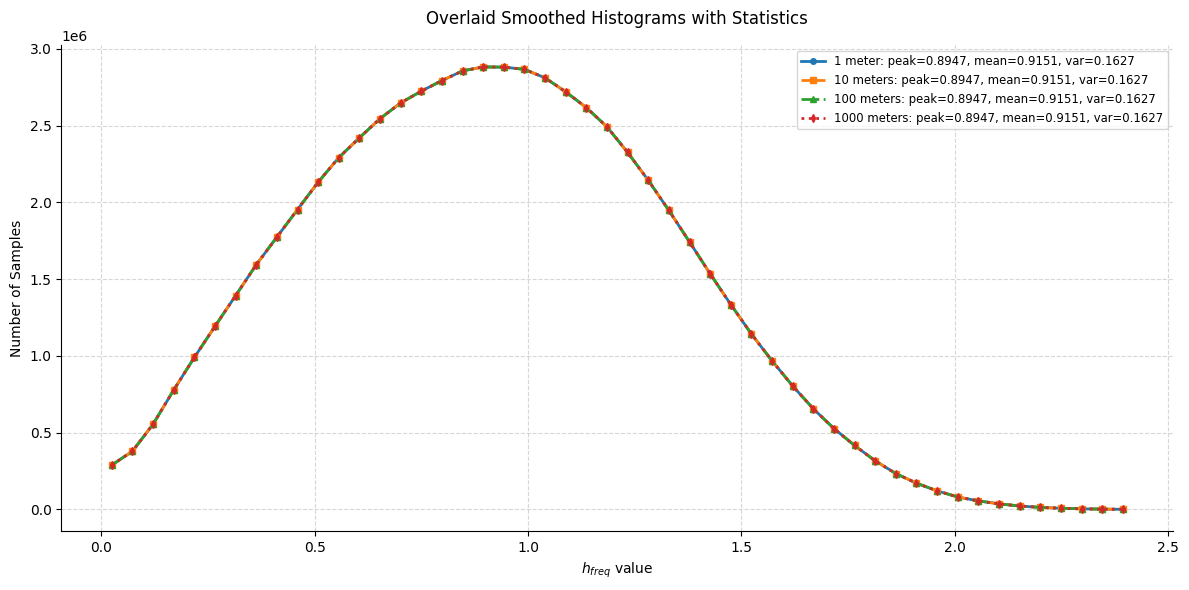

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

# Path to your .npz file
npz_path = os.path.join(save_dir, "channel_freqs.npz")

# The four keys you want to plot
keys = [
    "channel_freqs_dis_1m",
    "channel_freqs_dis_10m",
    "channel_freqs_dis_100m",
    "channel_freqs_dis_1000m",
]
titles = [
    "1 meter",
    "10 meters",
    "100 meters",
    "1000 meters",
]
line_styles = ["-", "--", "-.", ":"]
markers = ["o", "s", "^", "d"]
# Load all data at once
with np.load(npz_path, allow_pickle=True) as data:
    all_data = {k: data[k] for k in keys}

fig, ax = plt.subplots(figsize=(12, 6))

for i, key in enumerate(keys):
    h = all_data[key]

    # flatten
    vals = h.flatten()

    # compute statistics
    mean_val = np.mean(vals)
    var_val = np.var(vals)

    # histogram
    counts, bins = np.histogram(vals, bins=50)
    centers = (bins[:-1] + bins[1:]) / 2

    # smooth the counts
    counts_smooth = uniform_filter1d(counts, size=5)

    # find peak
    peak_center = centers[np.argmax(counts_smooth)]

    # plot filled step in background
    # ax.step(centers, counts, where='mid', alpha=0.2, linewidth=1)
    # ax.fill_between(centers, counts, step='mid', alpha=0.05)

    # plot smoothed outline + stats in label
    ax.plot(
        centers,
        counts_smooth,
        linewidth=2,
        linestyle=line_styles[i % len(line_styles)],
        marker=markers[i % len(markers)],
        markersize=4,
        label=(
            f"{titles[i]}: "
            f"peak={peak_center:.4f}, "
            f"mean={mean_val:.4f}, "
            f"var={var_val:.4f}"
        ),
    )

# styling
ax.set_title("Overlaid Smoothed Histograms with Statistics", pad=15)
ax.set_xlabel("$h_{freq}$ value")
ax.set_ylabel("Number of Samples")
ax.grid(which="major", linestyle="--", alpha=0.5)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

ax.legend(loc="upper right", fontsize="small")
plt.tight_layout()

# show (or save)
plt.savefig(os.path.join(save_dir, "h_freq_distance.png"), dpi=200)
plt.show()

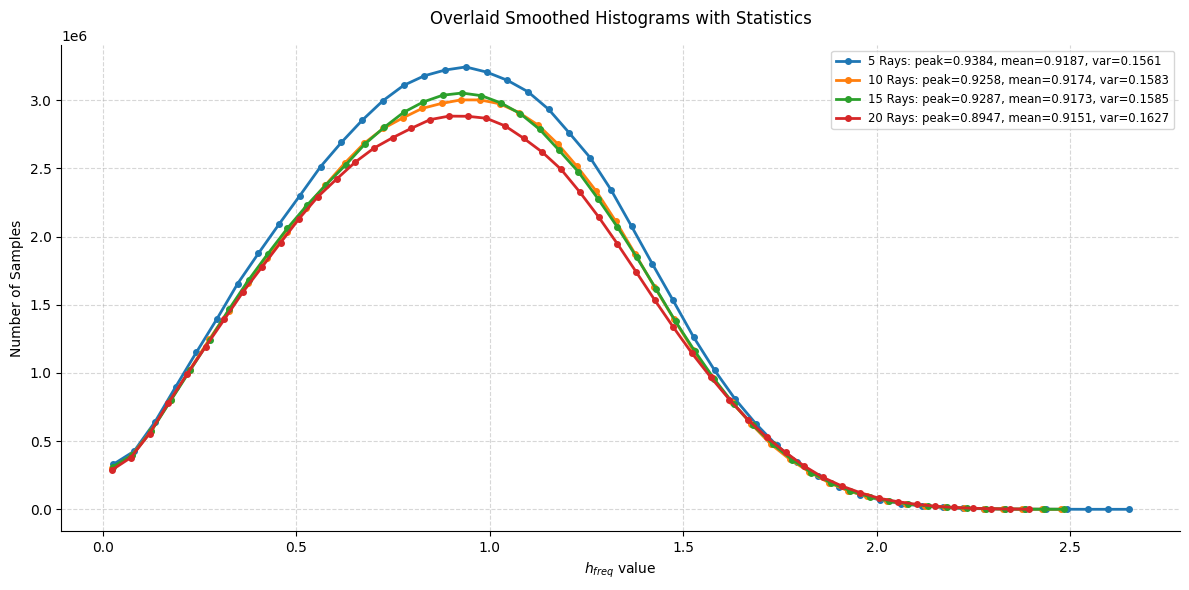

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

# Path to your .npz file
npz_path = os.path.join(save_dir, "channel_freqs.npz")

# The four keys you want to plot
keys = [
    "channel_freqs_5_rays",
    "channel_freqs_10_rays",
    "channel_freqs_15_rays",
    "channel_freqs_20_rays",
]
titles = [
    "5 Rays",
    "10 Rays",
    "15 Rays",
    "20 Rays",
]

# Load all data at once
with np.load(npz_path, allow_pickle=True) as data:
    all_data = {k: data[k] for k in keys}

fig, ax = plt.subplots(figsize=(12, 6))

for i, key in enumerate(keys):
    h = all_data[key]

    # flatten
    vals = h.flatten()

    # compute statistics
    mean_val = np.mean(vals)
    var_val = np.var(vals)

    # histogram
    counts, bins = np.histogram(vals, bins=50)
    centers = (bins[:-1] + bins[1:]) / 2

    # smooth the counts
    counts_smooth = uniform_filter1d(counts, size=5)

    # find peak
    peak_center = centers[np.argmax(counts_smooth)]

    # plot filled step in background
    # ax.step(centers, counts, where='mid', alpha=0.2, linewidth=1)
    # ax.fill_between(centers, counts, step='mid', alpha=0.05)

    # plot smoothed outline + stats in label
    ax.plot(
        centers,
        counts_smooth,
        linewidth=2,
        marker="o",
        markersize=4,
        label=(
            f"{titles[i]}: "
            f"peak={peak_center:.4f}, "
            f"mean={mean_val:.4f}, "
            f"var={var_val:.4f}"
        ),
    )

# styling
ax.set_title("Overlaid Smoothed Histograms with Statistics", pad=15)
ax.set_xlabel("$h_{freq}$ value")
ax.set_ylabel("Number of Samples")
ax.grid(which="major", linestyle="--", alpha=0.5)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

ax.legend(loc="upper right", fontsize="small")
plt.tight_layout()

# show (or save)
plt.savefig(os.path.join(save_dir, "h_freq_rays.png"), dpi=200)
plt.show()

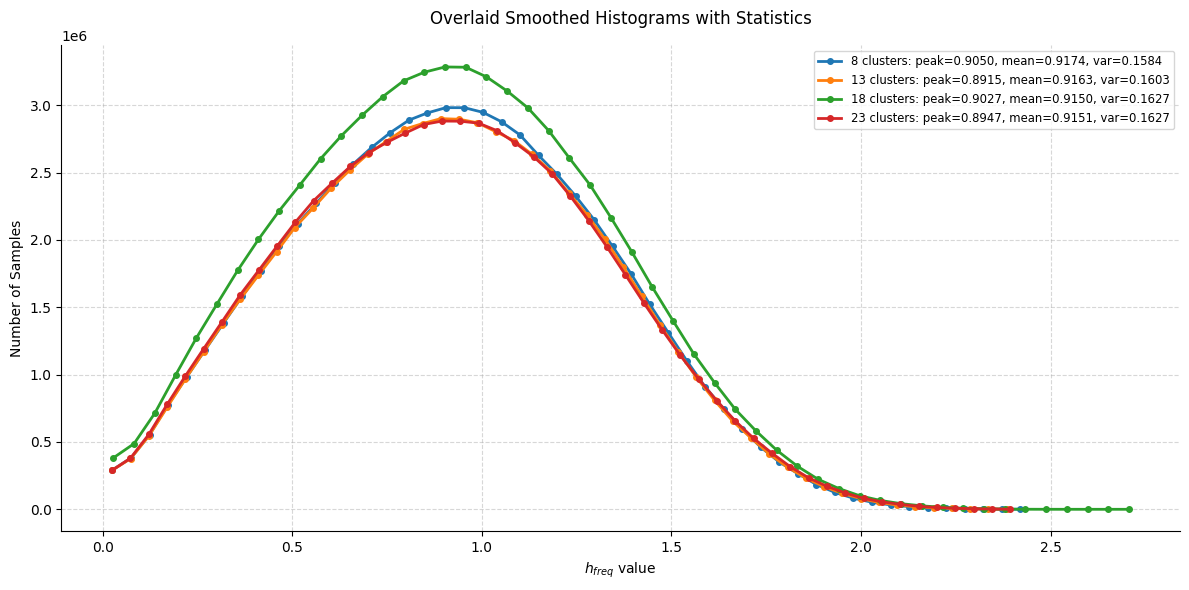

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

# Path to your .npz file
npz_path = os.path.join(save_dir, "channel_freqs.npz")

# The four keys you want to plot
keys = [
    "channel_freqs_8_clusters",
    "channel_freqs_13_clusters",
    "channel_freqs_18_clusters",
    "channel_freqs_23_clusters",
]
titles = [
    "8 clusters",
    "13 clusters",
    "18 clusters",
    "23 clusters",
]

# Load all data at once
with np.load(npz_path, allow_pickle=True) as data:
    all_data = {k: data[k] for k in keys}

fig, ax = plt.subplots(figsize=(12, 6))

for i, key in enumerate(keys):
    h = all_data[key]

    # flatten
    vals = h.flatten()

    # compute statistics
    mean_val = np.mean(vals)
    var_val = np.var(vals)

    # histogram
    counts, bins = np.histogram(vals, bins=50)
    centers = (bins[:-1] + bins[1:]) / 2

    # smooth the counts
    counts_smooth = uniform_filter1d(counts, size=5)

    # find peak
    peak_center = centers[np.argmax(counts_smooth)]

    # plot filled step in background
    # ax.step(centers, counts, where='mid', alpha=0.2, linewidth=1)
    # ax.fill_between(centers, counts, step='mid', alpha=0.05)

    # plot smoothed outline + stats in label
    ax.plot(
        centers,
        counts_smooth,
        linewidth=2,
        marker="o",
        markersize=4,
        label=(
            f"{titles[i]}: "
            f"peak={peak_center:.4f}, "
            f"mean={mean_val:.4f}, "
            f"var={var_val:.4f}"
        ),
    )

# styling
ax.set_title("Overlaid Smoothed Histograms with Statistics", pad=15)
ax.set_xlabel("$h_{freq}$ value")
ax.set_ylabel("Number of Samples")
ax.grid(which="major", linestyle="--", alpha=0.5)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

ax.legend(loc="upper right", fontsize="small")
plt.tight_layout()

# show (or save)
plt.savefig(os.path.join(save_dir, "h_freq_clusters.png"), dpi=200)
plt.show()

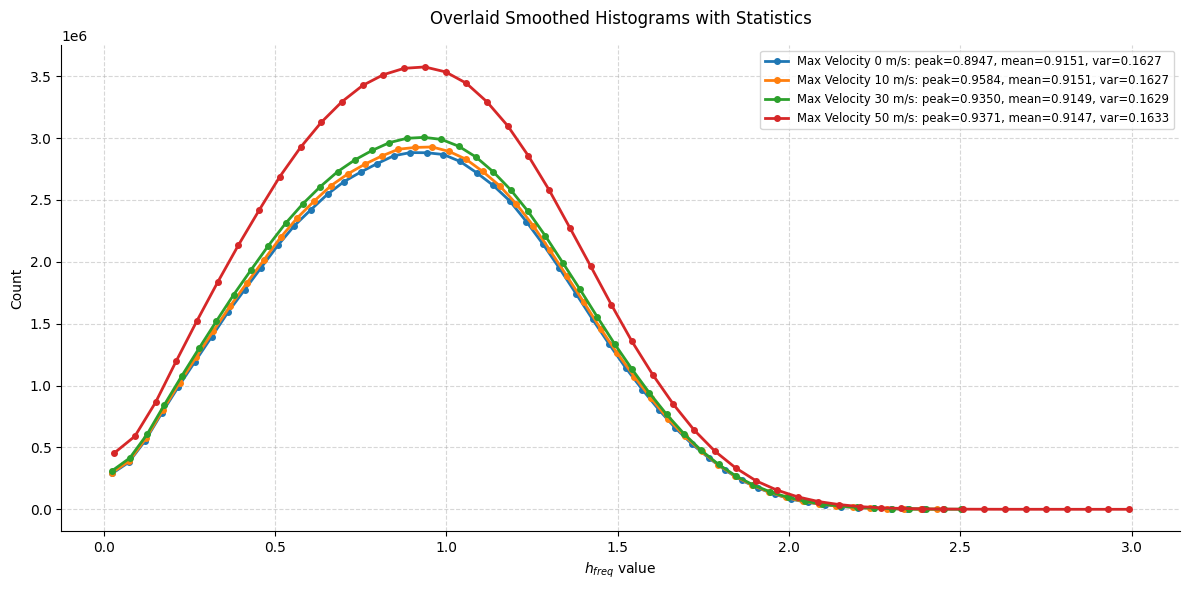

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

# Path to your .npz file
npz_path = os.path.join(save_dir, "channel_freqs.npz")

# The four keys you want to plot
keys = [
    "channel_freqs_vel_0",
    "channel_freqs_vel_10",
    "channel_freqs_vel_30",
    "channel_freqs_vel_50",
]
titles = [
    "Max Velocity 0 m/s",
    "Max Velocity 10 m/s",
    "Max Velocity 30 m/s",
    "Max Velocity 50 m/s",
]

# Load all data at once
with np.load(npz_path, allow_pickle=True) as data:
    all_data = {k: data[k] for k in keys}

fig, ax = plt.subplots(figsize=(12, 6))

for i, key in enumerate(keys):
    h = all_data[key]

    # flatten
    vals = h.flatten()

    # compute statistics
    mean_val = np.mean(vals)
    var_val = np.var(vals)

    # histogram
    counts, bins = np.histogram(vals, bins=50)
    centers = (bins[:-1] + bins[1:]) / 2

    # smooth the counts
    counts_smooth = uniform_filter1d(counts, size=5)

    # find peak
    peak_center = centers[np.argmax(counts_smooth)]

    # plot filled step in background
    # ax.step(centers, counts, where='mid', alpha=0.2, linewidth=1)
    # ax.fill_between(centers, counts, step='mid', alpha=0.05)

    # plot smoothed outline + stats in label
    ax.plot(
        centers,
        counts_smooth,
        linewidth=2,
        marker="o",
        markersize=4,
        label=(
            f"{titles[i]}: "
            f"peak={peak_center:.4f}, "
            f"mean={mean_val:.4f}, "
            f"var={var_val:.4f}"
        ),
    )

# styling
ax.set_title("Overlaid Smoothed Histograms with Statistics", pad=15)
ax.set_xlabel("$h_{freq}$ value")
ax.set_ylabel("Count")
ax.grid(which="major", linestyle="--", alpha=0.5)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

ax.legend(loc="upper right", fontsize="small")
plt.tight_layout()

# show (or save)
plt.savefig(os.path.join(save_dir, "h_freq_vels.png"), dpi=200)
plt.show()

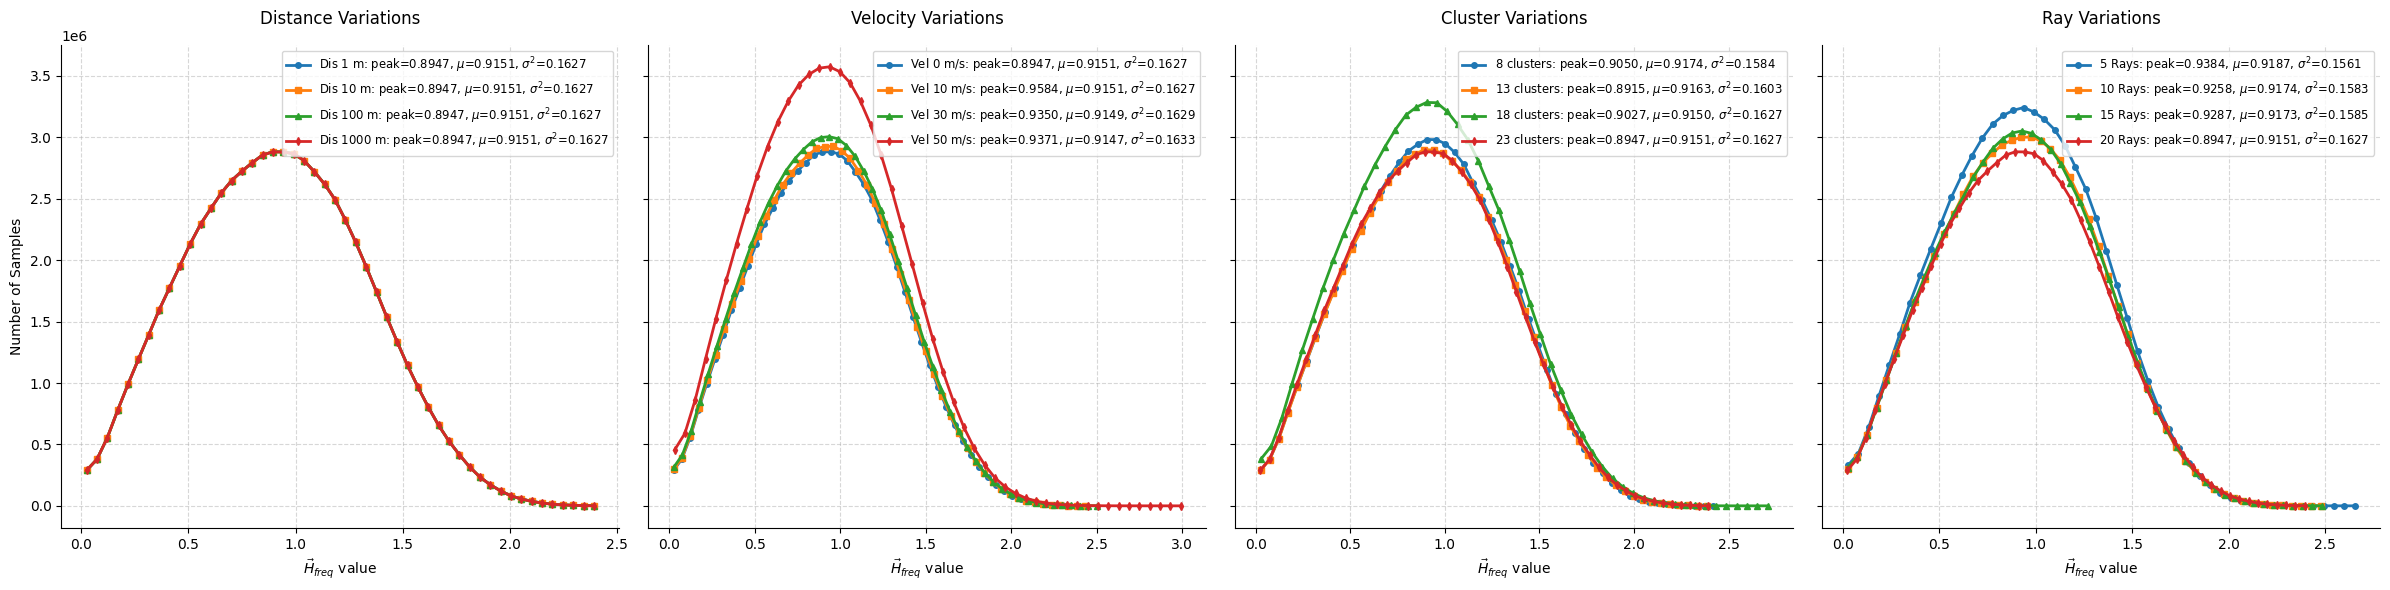

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

# Path to your .npz file
npz_path = os.path.join(save_dir, "channel_freqs.npz")

# Define the keys and titles for each subplot
plot_configs = [
    {
        "keys": [
            "channel_freqs_dis_1m",
            "channel_freqs_dis_10m",
            "channel_freqs_dis_100m",
            "channel_freqs_dis_1000m",
        ],
        "titles": ["Dis 1 m", "Dis 10 m", "Dis 100 m", "Dis 1000 m"],
        "subplot_title": "Distance Variations",
    },
    {
        "keys": [
            "channel_freqs_vel_0",
            "channel_freqs_vel_10",
            "channel_freqs_vel_30",
            "channel_freqs_vel_50",
        ],
        "titles": ["Vel 0 m/s", "Vel 10 m/s", "Vel 30 m/s", "Vel 50 m/s"],
        "subplot_title": "Velocity Variations",
    },
    {
        "keys": [
            "channel_freqs_8_clusters",
            "channel_freqs_13_clusters",
            "channel_freqs_18_clusters",
            "channel_freqs_23_clusters",
        ],
        "titles": ["8 clusters", "13 clusters", "18 clusters", "23 clusters"],
        "subplot_title": "Cluster Variations",
    },
    {
        "keys": [
            "channel_freqs_5_rays",
            "channel_freqs_10_rays",
            "channel_freqs_15_rays",
            "channel_freqs_20_rays",
        ],
        "titles": ["5 Rays", "10 Rays", "15 Rays", "20 Rays"],
        "subplot_title": "Ray Variations",
    },
]

# Load all data at once
with np.load(npz_path, allow_pickle=True) as data:
    all_data = {k: data[k] for config in plot_configs for k in config["keys"]}

line_styles = ["-", "-", "-", "-"]
markers = ["o", "s", "^", "d"]
# Create figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharey=True)

for idx, config in enumerate(plot_configs):
    ax = axes[idx]
    keys = config["keys"]
    titles = config["titles"]

    for i, key in enumerate(keys):
        h = all_data[key]

        # Flatten
        vals = h.flatten()

        # Compute statistics
        mean_val = np.mean(vals)
        var_val = np.var(vals)

        # Histogram
        counts, bins = np.histogram(vals, bins=50)
        centers = (bins[:-1] + bins[1:]) / 2

        # Smooth the counts
        counts_smooth = uniform_filter1d(counts, size=5)

        # Find peak
        peak_center = centers[np.argmax(counts_smooth)]

        # Plot smoothed outline + stats in label
        ax.plot(
            centers,
            counts_smooth,
            linewidth=2,
            linestyle=line_styles[i % len(line_styles)],
            marker=markers[i % len(markers)],
            markersize=4,
            label=(
                f"{titles[i]}: "
                f"peak={peak_center:.4f}, "
                f"$\\mu$={mean_val:.4f}, "
                f"$\\sigma^2$={var_val:.4f}"
            ),
        )

    # Styling for each subplot
    ax.set_title(config["subplot_title"], pad=15)
    ax.set_xlabel("$\\vec{H}_{freq}$ value")
    if idx == 0:
        ax.set_ylabel("Number of Samples")
    ax.grid(which="major", linestyle="--", alpha=0.5)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    ax.legend(loc="upper right", fontsize="small")

# Adjust layout to prevent overlap
plt.tight_layout()

# Save and show
plt.savefig(os.path.join(save_dir, "h_freq_combined.png"), dpi=200)
plt.show()

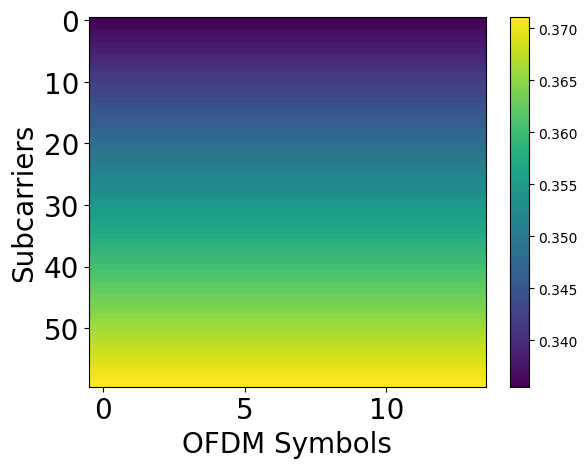

In [19]:
from src.channels.cdl_channel import (
    sampling_channel_freq,
)
from src.settings.antenna import bs_array, ut_array
from src.settings.config import (
    carrier_frequency,
    cdl_model,
    delay_spread,
    direction,
)
import numpy as np
from sionna.channel.tr38901 import CDL
import matplotlib.pyplot as plt

cdl = CDL(
    cdl_model,
    delay_spread,
    carrier_frequency,
    ut_array,
    bs_array,
    direction,
    min_speed=0,
)

h_freq = sampling_channel_freq(cdl=cdl)

# Assuming x_signal is a 2D array
# Display the array as an image
im = plt.imshow(np.abs(h_freq[0, 0, 0, 0, 0].numpy()).T, cmap="viridis", aspect="auto")

plt.colorbar(im)

# Set labels for the axes with increased fontsize
plt.xlabel("OFDM Symbols", fontsize=20)
plt.ylabel("Subcarriers", fontsize=20)

# Adjust tick parameters to increase the size of tick labels
plt.tick_params(axis="both", which="major", labelsize=20)
# Show the plot
plt.show()
# plt.savefig("./results/channel_freq_domain.png")

import os

save_dir = "results/eval/hitograms"
os.makedirs(save_dir, exist_ok=True)
npz_path = os.path.join(save_dir, "channel_tf.npz")

key = f"cluster8"
new_data = np.abs(h_freq[0, 0, 0, 0, 0].numpy()).T

# If file exists, load and overwrite the key
if os.path.exists(npz_path):
    existing_data = dict(np.load(npz_path, allow_pickle=True))
    existing_data[key] = new_data  # Overwrite
    np.savez(npz_path, **existing_data)
else:
    # Save new data to .npz file
    np.savez(npz_path, **{key: new_data})

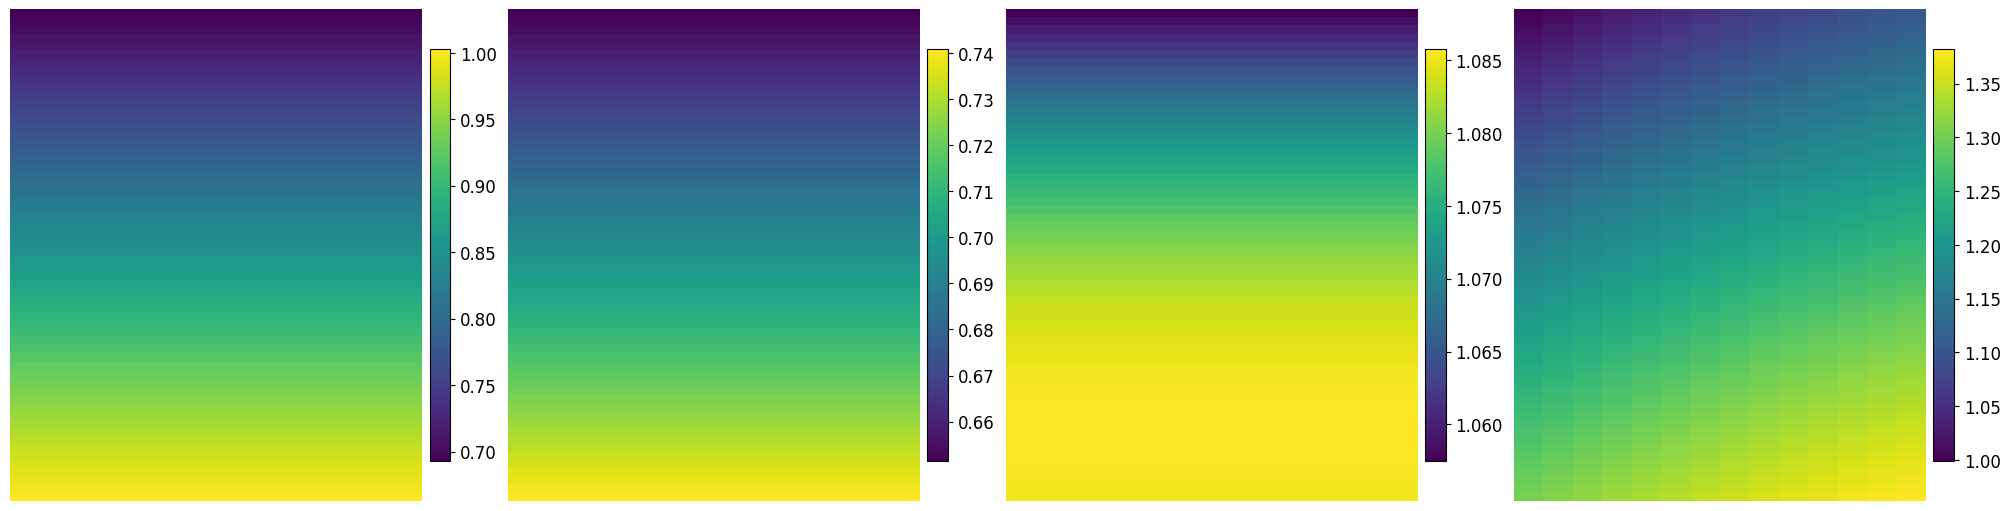

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ---- your parameters ----
save_dir = "results/eval/hitograms"
npz_path = os.path.join(save_dir, "channel_tf.npz")
keys = ["vel0", "cluster8", "ray5", "vel50"]

# ---- load data ----
if not os.path.exists(npz_path):
    raise FileNotFoundError(f"No file at {npz_path}")

data_dict = dict(np.load(npz_path, allow_pickle=True))
missing = [k for k in keys if k not in data_dict]
if missing:
    raise KeyError(f"Missing keys in {npz_path}: {missing}")

# ---- plotting ----
fig, axes = plt.subplots(1, 4, figsize=(20, 5), constrained_layout=True)

for ax, key in zip(axes, keys):
    arr = data_dict[key]
    vmin_local, vmax_local = arr.min(), arr.max()

    im = ax.imshow(arr, cmap="viridis", aspect="auto", vmin=vmin_local, vmax=vmax_local)
    # remove all axis elements
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

    # per‐axis colorbar
    cbar = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.05, pad=0.02)
    # keep only the tick labels on the cbar
    cbar.ax.tick_params(labelsize=12)
    # no label text, ticks will show the numeric range
    cbar.set_label("")

plt.show()
plt.close(fig)